<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/DSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Tewabe Melkamu

Date: 3/13/2025

DSR_Data Collection

In [19]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-melkatewabe')

In [20]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the FAO GAUL 2015 dataset.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# Load the first image from ESA WorldCover and clip it to Taiwan.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# Class definitions from ESA WorldCover:
# 50 = Built-up, 80 = Permanent water bodies.
# We remove both built-up and permanent water by keeping pixels that are not 50 and not 80.
mask = worldcover.neq(50).And(worldcover.neq(80))

# Create an interactive map (optional).
# Map = geemap.Map(center=[23.5, 121], zoom=7)

# -------------------------------------------------------------------
# 3. Loop through each year from 2000 to 2025 and export the yearly mean GMT_0800_DSR
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    # Define the date range for the year.
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    # Compute the mean GMT_0800_DSR image for the year using the MODIS/062/MCD18A1 product.
    gmt_dsr = (ee.ImageCollection("MODIS/062/MCD18A1")
                .filterDate(start_date, end_date)
                .filterBounds(taiwan)
                .select('GMT_0600_DSR')
                .mean()
                .clip(taiwan))

    # Multiply by a scale factor if needed. For example, if the scale factor is 0.001:
    #gmt_dsr_scaled = gmt_dsr.multiply(0.001)

    # Apply the mask.
    gmt_dsr_masked = gmt_dsr.updateMask(mask)

    # Optional: Add layers to the map for visualization.
     #Map.addLayer(gmt_dsr_scaled, {'min': 0, 'max': 1, 'palette': ['blue', 'green', 'red']}, f'GMT_0300_DSR {year}')
     #Map.addLayer(gmt_dsr_masked, {'min': 0, 'max': 1, 'palette': ['blue', 'green', 'red']}, f'GMT_0300_DSR Masked {year}')

    # Define and start the export task.
    task = ee.batch.Export.image.toDrive(
        image=gmt_dsr_masked,
        description=f'DSR_{year}',
        folder='Taiwan_DSR',  # Update this to your desired Drive folder.
        fileNamePrefix=f'DSR_{year}',
        region=taiwan.geometry().bounds().getInfo()['coordinates'],
        scale=1000,  # MODIS resolution is approximately 1 km.
        crs='EPSG:32651',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for {year} started. Please check your GEE tasks and Google Drive.")

# Optionally, display the interactive map.
#Map


Processing year: 2000
Export task for 2000 started. Please check your GEE tasks and Google Drive.
Processing year: 2001
Export task for 2001 started. Please check your GEE tasks and Google Drive.
Processing year: 2002
Export task for 2002 started. Please check your GEE tasks and Google Drive.
Processing year: 2003
Export task for 2003 started. Please check your GEE tasks and Google Drive.
Processing year: 2004
Export task for 2004 started. Please check your GEE tasks and Google Drive.
Processing year: 2005
Export task for 2005 started. Please check your GEE tasks and Google Drive.
Processing year: 2006
Export task for 2006 started. Please check your GEE tasks and Google Drive.
Processing year: 2007
Export task for 2007 started. Please check your GEE tasks and Google Drive.
Processing year: 2008
Export task for 2008 started. Please check your GEE tasks and Google Drive.
Processing year: 2009
Export task for 2009 started. Please check your GEE tasks and Google Drive.
Processing year: 201

In [18]:
# 1. Define Ethiopia's boundary using a FeatureCollection.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# 2. Load the MODIS/062/MCD18A1 image collection, filter by date (2020) and by location (Ethiopia).
dataset = ee.ImageCollection("MODIS/062/MCD18A1") \
    .filter(ee.Filter.date('2024-01-01', '2024-01-03')) \
    .filterBounds(taiwan.geometry())

# Select the "GMT_0300_DSR" band, compute the mean over the period, and clip to Ethiopia.
dsr = dataset.select('GMT_0600_DSR').mean().clip(taiwan.geometry())

# (Optional) If a scaling factor is required for the "GMT_0300_DSR" band,
# apply it here. For example, if the scaling factor is 0.001, uncomment the next line:
# gmt_dsr = gmt_dsr.multiply(0.001)

# 3. Create a mask to remove water bodies.
# Load ESA WorldCover and clip to Ethiopia.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# In ESA WorldCover, class 80 represents permanent water bodies.
mask = worldcover.neq(80)
# Apply the water body mask to the GMT_0300_DSR image.
dsr_masked = dsr.updateMask(mask)

# 4. Visualization parameters for surface albedo.
dsr_vis = {
    'min': 0,
    'max': 300,
    'palette': ['white', 'yellow', 'orange', 'red']
}

# 5. Create an interactive map centered on Ethiopia.
Map = geemap.Map(center=[23.5, 121], zoom=7)
Map.addLayer(dsr_masked , dsr_vis, 'Masked_DSR')
Map.addLayer(taiwan, {}, 'Taiwan Boundary')
Map.addLayerControl()  # Enable layer control
Map


Map(center=[23.5, 121], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [ ]:
# 6. Export the masked, yearly-mean NDWI image to Google Drive.
export_task = ee.batch.Export.image.toDrive(
    image=dsr_masked ,
    description='DSR_2020',
    folder='DEM',
    fileNamePrefix='DSR_2020',
    region=ethiopia.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # Adjust scale (500 m is typical for MODIS products)
    crs='EPSG:32637',
    maxPixels=1e13
)
export_task.start()
print("export started")

export started


In [2]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.7 MB/s eta 0:00:00


Metadata:
driver: GTiff
dtype: float32
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


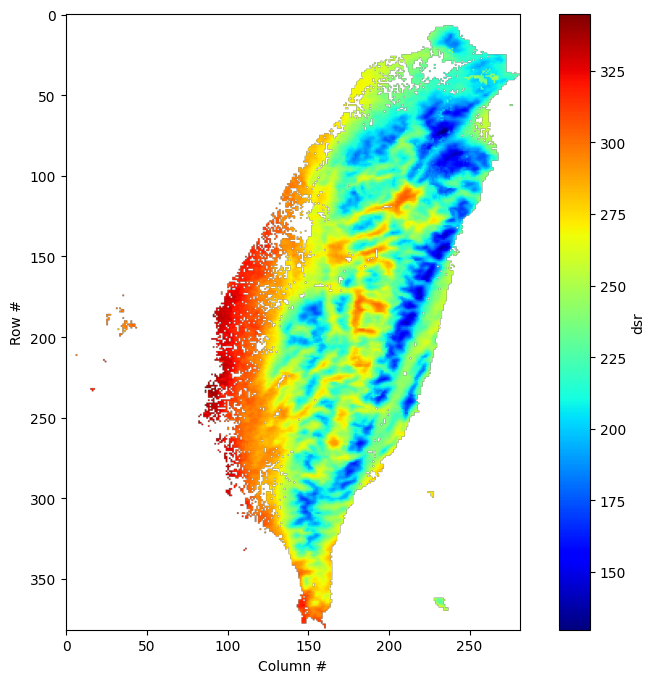

In [23]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/Taiwan_DSR/DSR_2010.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='dsr')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

